* Plot radio dynamic spectra from ORFEES and NenuFAR.
* Plot timeseries of STIX, ORFEES, and NenuFAR.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import glob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import astropy.units as u
from astropy.time import Time
from astropy.io import fits
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from radiospectra.spectrogram2 import Spectrogram
from stixpy.net.client import STIXClient  # This registers the STIX client with Fido
from stixpy.product import Product
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from matplotlib.collections import QuadMesh
import matplotlib as mpl
mpl.rcParams.update({'font.size': 14})
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00' # use precise epoch
try: mdates.set_epoch('1970-01-01T00:00:00')
except: pass

# import time, os

data_dir = '/home/mnedal/data'

In [3]:
mydate = '2025-03-25'

year, month, day = mydate.split('-')

In [4]:
files = glob.glob(f'{data_dir}/int_orf{year}{month}{day}_*.fts')

orfees = fits.open(files[0])
orfees_i = np.hstack([orfees[2].data[f'STOKESI_B{i}'] for i in range(1, 6)]).T
orfees_data = orfees_i.T

orfees_time_str = orfees[0].header['DATE-OBS']
orfees_times = Time(orfees_time_str) + (orfees[2].data['TIME_B1']/1000)*u.s # times are not the same for all sub spectra!
orfees_freqs = np.hstack([orfees[1].data[f'FREQ_B{i}'] for i in range(1, 6)])*u.MHz

In [82]:
# convert ORFEES data to a DataFrame and plot it to determine the quiet period, which will be divided by later.
df_orfees = pd.DataFrame(data=orfees_data, index=orfees_times, columns=orfees_freqs.value.flatten())
df_orfees.index = [t.datetime for t in df_orfees.index]
df_orfees.head(3)

,144.130005,144.520004,144.910004,145.300003,145.690002,146.960007,148.089996,148.429993,148.820007,149.210007,...,990.729980,992.289978,993.859985,995.419983,996.979980,998.539978,1000.109985,1001.669983,1003.229980,1004.700012
2025-03-25 06:56:06.740,38.740002,49.170002,55.987503,53.974998,55.317501,52.805,53.143330,54.192501,55.035000,54.482498,...,42.108749,41.434372,46.627499,44.325623,40.367504,47.371876,46.206249,51.374996,53.906246,70.457146
2025-03-25 06:56:06.840,40.230003,50.660000,53.490002,52.929996,54.639999,53.625,53.639999,53.817501,53.162498,53.737503,...,42.108749,42.340622,46.627499,44.325623,41.341877,47.371876,47.474998,51.374996,53.906246,70.457146
2025-03-25 06:56:06.940,47.680000,55.130001,54.782501,53.974998,55.472500,54.430,53.639999,54.192501,53.910000,54.850002,...,42.108749,42.787498,46.627499,41.891243,39.887505,47.371876,47.493752,52.293747,53.906246,70.457146


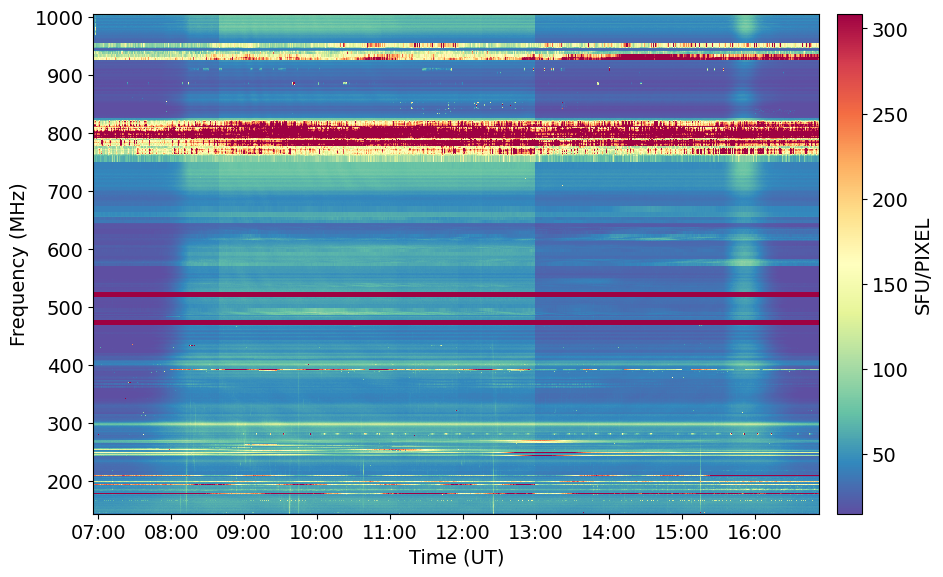

In [26]:
v_range = np.nanpercentile(df_orfees, [1,96])

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees.index, df_orfees.columns, df_orfees.T,
                   vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

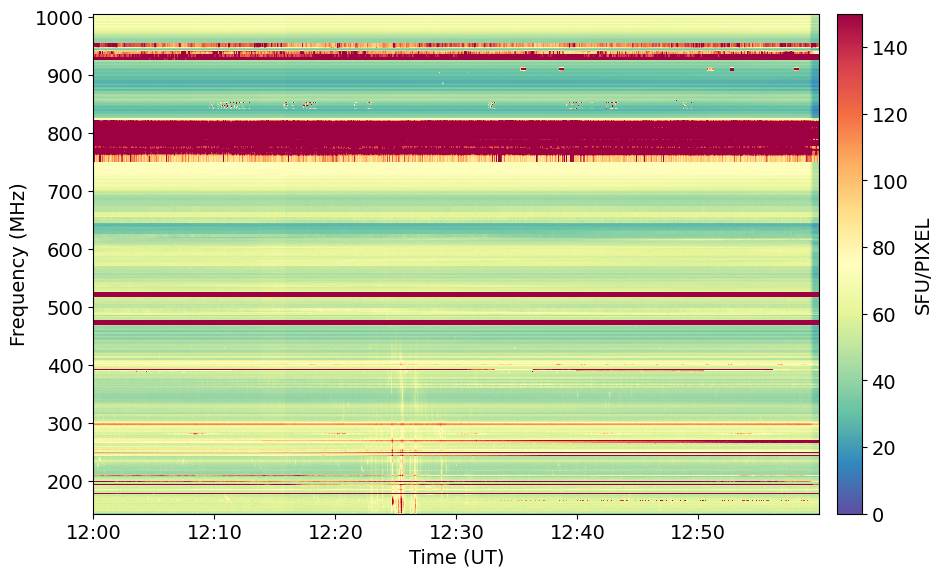

In [79]:
start_time = pd.to_datetime('2025-03-25T12:00:00')
end_time   = pd.to_datetime('2025-03-25T13:00:00')

start_nearest = df_orfees.index.asof(start_time)
end_nearest   = df_orfees.index.asof(end_time)

df_sliced = df_orfees.loc[start_nearest:end_nearest]

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_sliced.index, df_sliced.columns, df_sliced.T,
                   vmin=0, vmax=150, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [89]:
bkg_removal_method = 1

if bkg_removal_method==1:
    print('Find the exact or earlier timestamps, and slice at this window')
    start_time = pd.to_datetime('2025-03-25T07:00:00')
    end_time   = pd.to_datetime('2025-03-25T07:15:00')
    
    start_nearest = df_orfees.index.asof(start_time)
    end_nearest   = df_orfees.index.asof(end_time)
    
    subdf = df_orfees.loc[start_nearest:end_nearest]
    df_sliced = subdf.mean(axis=0)
    # print(start_nearest, end_nearest, sep='\n')
    print('Remove the background by dividing the data by the quiet background')
    df_orfees_nobkg = df_orfees/df_sliced

elif bkg_removal_method==2:
    print('### Find the nearest row to a single timestamp')
    start_time = pd.to_datetime('2025-03-25T07:00:00')
    
    nearest_idx = df_orfees.index.get_indexer([start_time], method='nearest')[0]
    df_sliced = df_orfees.iloc[nearest_idx]
    
    actual_time = df_orfees.index[nearest_idx]
    # print(actual_time)
    print('Remove the background by dividing the data by the quiet background')
    df_orfees_nobkg = df_orfees/df_sliced

Find the exact or earlier timestamps, and slice at this window
Remove the background by dividing the data by the quiet background


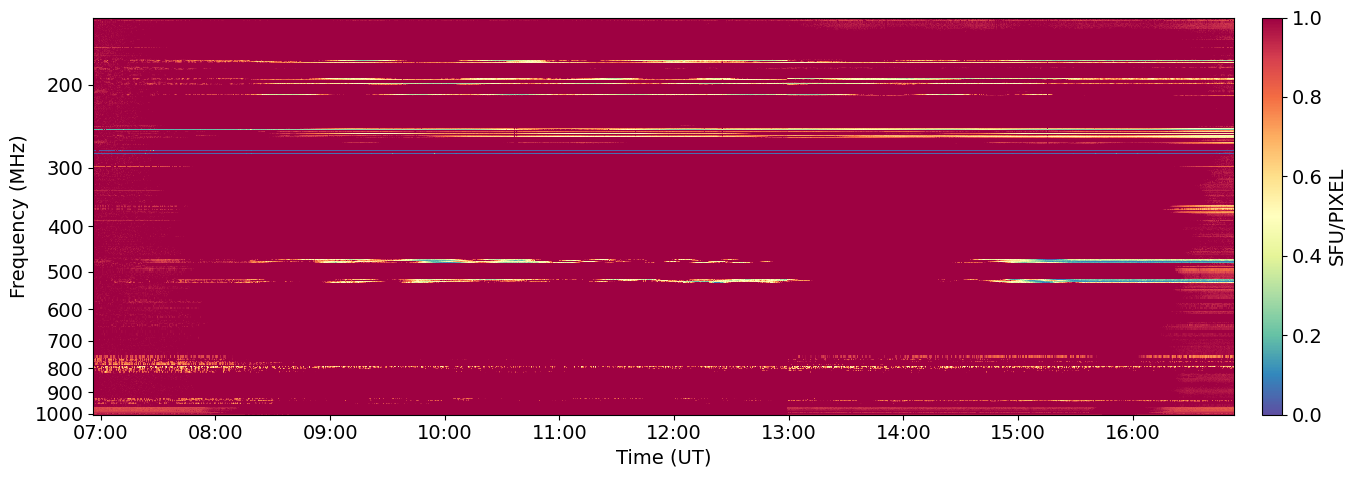

In [91]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_nobkg.index, df_orfees_nobkg.columns, df_orfees_nobkg.T,
                   # vmin=v_range[0], vmax=v_range[1],
                   vmin=0, vmax=1,
                   cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [92]:
df_orfees_1s = df_orfees.resample('1S').mean()

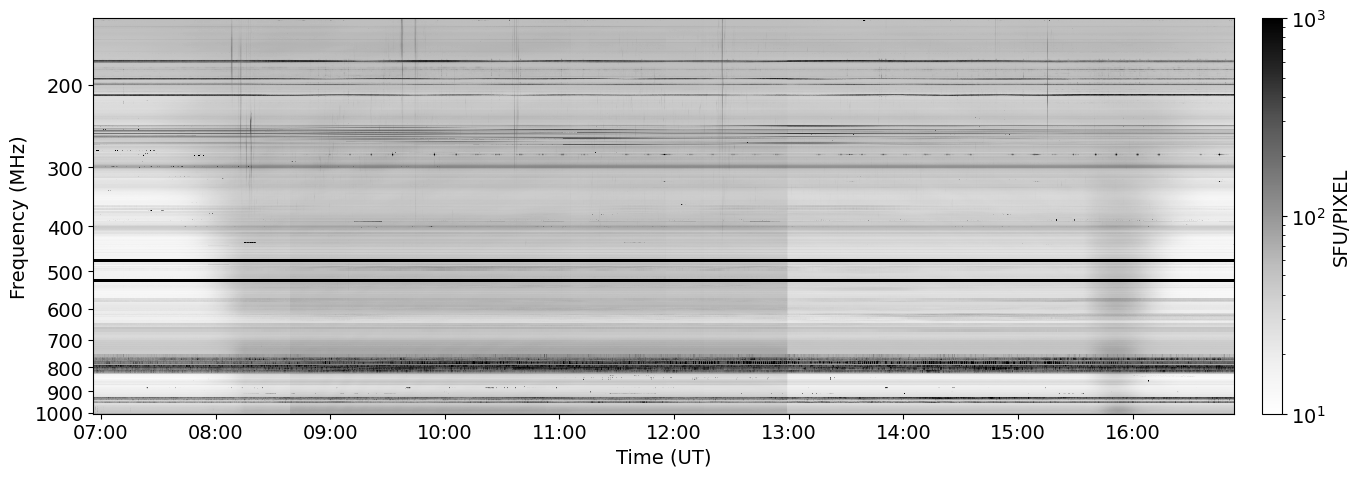

In [118]:
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_orfees_1s.index, df_orfees_1s.columns, df_orfees_1s.T,
                   norm=LogNorm(vmin=1e1, vmax=1e3),
                   # norm=LogNorm(vmin=np.nanpercentile(df_orfees_1s, 0), vmax=np.nanpercentile(df_orfees_1s, 90)),
                   cmap='Greys')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

## Load NenuFAR data

In [125]:
nenufar_files = sorted(glob.glob('/home/mnedal/outputs/data/*'))
nenufar_files

['/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeII.pkl',
 '/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeIII_G1.pkl',
 '/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeIII_G2.npz',
 '/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeIII_G3.npz',
 '/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeIII_G4.pkl']

In [128]:
df_nenufar = pd.read_pickle(nenufar_files[4])

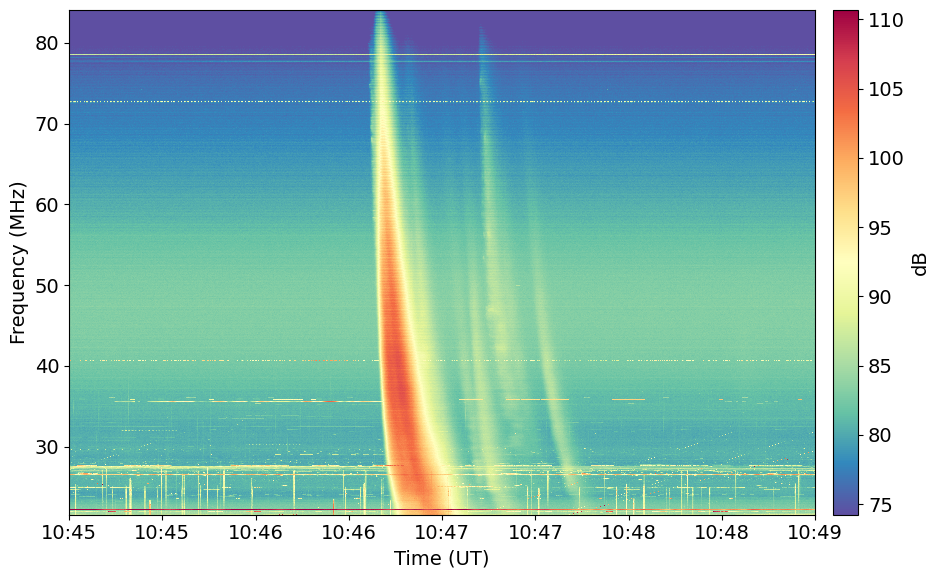

In [129]:
v_range = np.nanpercentile(df_nenufar, [7, 99.97])

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_nenufar.index, df_nenufar.columns, df_nenufar.T,
                   vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [130]:
df_nenufar.shape

(11445, 10240)

In [131]:
df_nenufar.index[0], df_nenufar.index[-1]

(Timestamp('2025-03-25 10:45:00.001964'),
 Timestamp('2025-03-25 10:49:00.000038'))

In [132]:
# slice nenufar to match orfees
start_time = pd.to_datetime(df_nenufar.index[0])
end_time   = pd.to_datetime(df_nenufar.index[-1])

start_nearest = df_orfees.index.asof(start_time)
end_nearest   = df_orfees.index.asof(end_time)

subdf_orfees = df_orfees.loc[start_nearest:end_nearest]
subdf_orfees.index[0], subdf_orfees.index[-1]

(Timestamp('2025-03-25 10:44:59.940000'),
 Timestamp('2025-03-25 10:48:59.940000'))

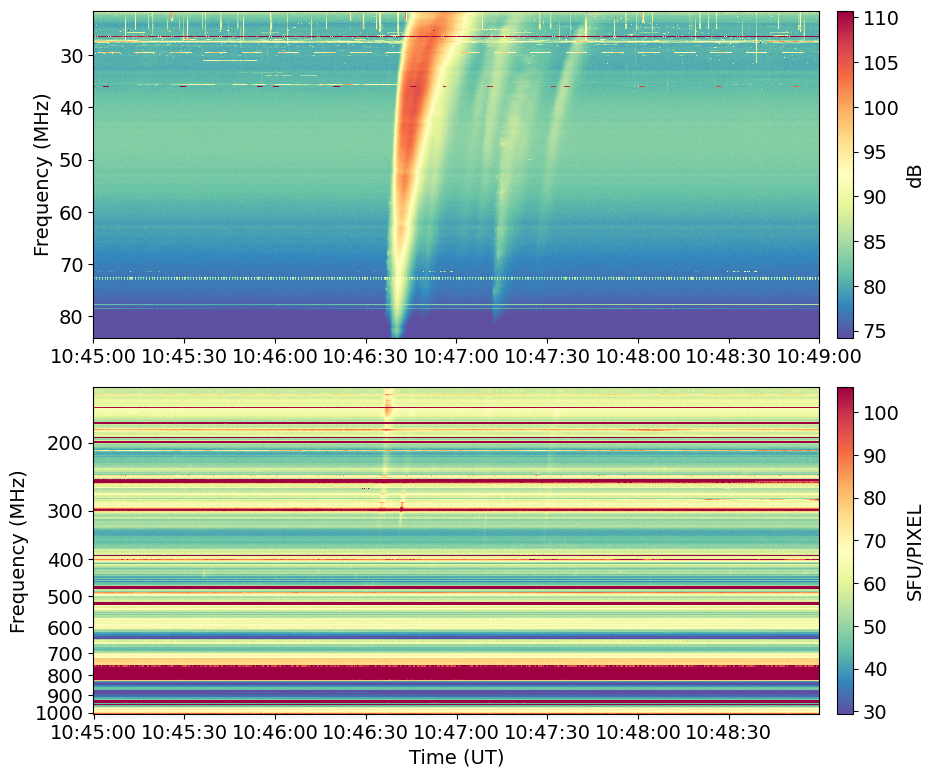

In [135]:
fig = plt.figure(figsize=[10,8])

v_range = np.nanpercentile(df_nenufar, [7, 99.97])
ax = fig.add_subplot(211)
pc = ax.pcolormesh(df_nenufar.index, df_nenufar.columns, df_nenufar.T,
                   vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

v_range = np.nanpercentile(subdf_orfees, [1, 90])
ax = fig.add_subplot(212)
pc = ax.pcolormesh(subdf_orfees.index, subdf_orfees.columns, subdf_orfees.T,
                   vmin=v_range[0], vmax=v_range[1], cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label=orfees[2].header['BUNIT'])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[::-1])
yticks = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
ax.set_yticks(yticks)
ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

fig.tight_layout()
plt.show()